In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader

import torch
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm


import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from HatefulMemesDataset import HatefulMemesDataset
from FeaturesDataset import FeaturesDataset
from CLIP_utils import get_features, get_lr, train_model, compute_accuracy

In [2]:
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'

In [3]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
#https://github.com/openai/CLIP
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004253 0.003016]]


In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000022EA4AF7430>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [7]:
train_dataset = HatefulMemesDataset(train_path, preprocess)
val_dataset = HatefulMemesDataset(dev_path, preprocess)

  0%|                                                                                          | 0/850 [00:00<?, ?it/s]

torch.Size([3, 224, 224]) its their character not their color that matters 

  0%|                                                                                          | 0/850 [00:00<?, ?it/s]


tensor(0) torch.Size([10])


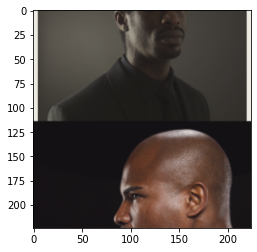

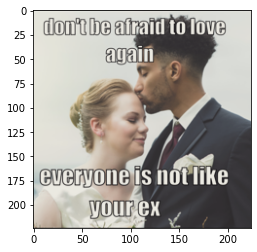

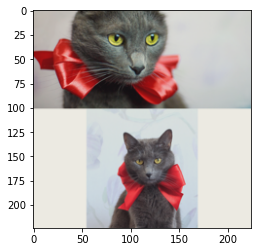

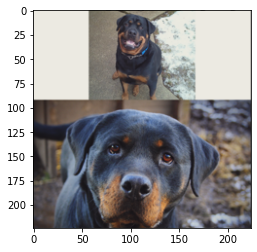

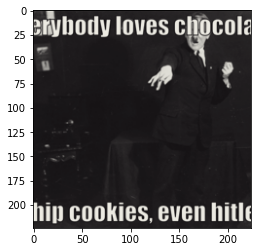

In [8]:
#Примеры изображений
for images, texts, labels in tqdm(DataLoader(train_dataset, batch_size=10)):
    print(images[0].shape, texts[0], labels[0] , labels.shape)
    break

    
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

for i in range(5):
    plt.imshow(T.ToPILImage()(images[i] * STD[:, None, None] + MEAN[:, None, None]))
    plt.show()

In [9]:
features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


In [10]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

In [11]:
input_shape = 1024
num_classes = 2

In [12]:
shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 500, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.671410, Train accuracy: 0.632353, Val accuracy: 0.590000
Epoch: 1 lr: 0.010000; Average loss: 0.578020, Train accuracy: 0.689765, Val accuracy: 0.542000
Epoch: 2 lr: 0.010000; Average loss: 0.523844, Train accuracy: 0.736941, Val accuracy: 0.614000
Epoch: 3 lr: 0.010000; Average loss: 0.512592, Train accuracy: 0.746000, Val accuracy: 0.626000
Epoch: 4 lr: 0.010000; Average loss: 0.489656, Train accuracy: 0.758471, Val accuracy: 0.600000
Epoch: 5 lr: 0.010000; 

Epoch: 79 lr: 0.001678; Average loss: 0.038595, Train accuracy: 0.987647, Val accuracy: 0.634000
Epoch: 80 lr: 0.001678; Average loss: 0.037235, Train accuracy: 0.984706, Val accuracy: 0.650000
Epoch: 81 lr: 0.001678; Average loss: 0.033665, Train accuracy: 0.988000, Val accuracy: 0.640000
Epoch: 82 lr: 0.001678; Average loss: 0.034517, Train accuracy: 0.987059, Val accuracy: 0.638000
Epoch: 83 lr: 0.001678; Average loss: 0.032581, Train accuracy: 0.988471, Val accuracy: 0.628000
Epoch: 84 lr: 0.001678; Average loss: 0.035531, Train accuracy: 0.987765, Val accuracy: 0.642000
Epoch: 85 lr: 0.001678; Average loss: 0.034035, Train accuracy: 0.987647, Val accuracy: 0.642000
Epoch: 86 lr: 0.001678; Average loss: 0.030479, Train accuracy: 0.988941, Val accuracy: 0.636000
Epoch: 87 lr: 0.001678; Average loss: 0.030611, Train accuracy: 0.988353, Val accuracy: 0.642000
Epoch: 88 lr: 0.001678; Average loss: 0.031798, Train accuracy: 0.988118, Val accuracy: 0.644000
Epoch: 89 lr: 0.001342; Averag

Epoch: 163 lr: 0.000281; Average loss: 0.017494, Train accuracy: 0.993647, Val accuracy: 0.638000
Epoch: 164 lr: 0.000281; Average loss: 0.014113, Train accuracy: 0.995059, Val accuracy: 0.640000
Epoch: 165 lr: 0.000281; Average loss: 0.013466, Train accuracy: 0.996000, Val accuracy: 0.640000
Epoch: 166 lr: 0.000281; Average loss: 0.015621, Train accuracy: 0.994471, Val accuracy: 0.638000
Epoch: 167 lr: 0.000281; Average loss: 0.016368, Train accuracy: 0.994235, Val accuracy: 0.640000
Epoch: 168 lr: 0.000281; Average loss: 0.013906, Train accuracy: 0.994824, Val accuracy: 0.638000
Epoch: 169 lr: 0.000225; Average loss: 0.014300, Train accuracy: 0.994588, Val accuracy: 0.638000
Epoch: 170 lr: 0.000225; Average loss: 0.011109, Train accuracy: 0.996000, Val accuracy: 0.642000
Epoch: 171 lr: 0.000225; Average loss: 0.016393, Train accuracy: 0.994471, Val accuracy: 0.638000
Epoch: 172 lr: 0.000225; Average loss: 0.013969, Train accuracy: 0.995176, Val accuracy: 0.638000
Epoch: 173 lr: 0.000

Epoch: 248 lr: 0.000047; Average loss: 0.013846, Train accuracy: 0.995059, Val accuracy: 0.640000
Epoch: 249 lr: 0.000038; Average loss: 0.012532, Train accuracy: 0.995882, Val accuracy: 0.640000
Epoch: 250 lr: 0.000038; Average loss: 0.012501, Train accuracy: 0.995647, Val accuracy: 0.644000
Epoch: 251 lr: 0.000038; Average loss: 0.011047, Train accuracy: 0.996353, Val accuracy: 0.640000
Epoch: 252 lr: 0.000038; Average loss: 0.012323, Train accuracy: 0.995176, Val accuracy: 0.642000
Epoch: 253 lr: 0.000038; Average loss: 0.011701, Train accuracy: 0.996000, Val accuracy: 0.644000
Epoch: 254 lr: 0.000038; Average loss: 0.010962, Train accuracy: 0.995882, Val accuracy: 0.640000
Epoch: 255 lr: 0.000038; Average loss: 0.012159, Train accuracy: 0.996706, Val accuracy: 0.642000
Epoch: 256 lr: 0.000038; Average loss: 0.011585, Train accuracy: 0.996353, Val accuracy: 0.642000
Epoch: 257 lr: 0.000038; Average loss: 0.010502, Train accuracy: 0.996706, Val accuracy: 0.640000
Epoch: 258 lr: 0.000

Epoch: 332 lr: 0.000006; Average loss: 0.011421, Train accuracy: 0.996588, Val accuracy: 0.640000
Epoch: 333 lr: 0.000006; Average loss: 0.009993, Train accuracy: 0.996000, Val accuracy: 0.640000
Epoch: 334 lr: 0.000006; Average loss: 0.011486, Train accuracy: 0.996353, Val accuracy: 0.640000
Epoch: 335 lr: 0.000006; Average loss: 0.015238, Train accuracy: 0.994588, Val accuracy: 0.638000
Epoch: 336 lr: 0.000006; Average loss: 0.010481, Train accuracy: 0.996471, Val accuracy: 0.638000
Epoch: 337 lr: 0.000006; Average loss: 0.010354, Train accuracy: 0.996353, Val accuracy: 0.638000
Epoch: 338 lr: 0.000006; Average loss: 0.008673, Train accuracy: 0.997059, Val accuracy: 0.640000
Epoch: 339 lr: 0.000005; Average loss: 0.010834, Train accuracy: 0.995529, Val accuracy: 0.640000
Epoch: 340 lr: 0.000005; Average loss: 0.012063, Train accuracy: 0.995529, Val accuracy: 0.640000
Epoch: 341 lr: 0.000005; Average loss: 0.010357, Train accuracy: 0.996353, Val accuracy: 0.640000
Epoch: 342 lr: 0.000

Epoch: 417 lr: 0.000001; Average loss: 0.011199, Train accuracy: 0.995176, Val accuracy: 0.636000
Epoch: 418 lr: 0.000001; Average loss: 0.011308, Train accuracy: 0.995882, Val accuracy: 0.634000
Epoch: 419 lr: 0.000001; Average loss: 0.012829, Train accuracy: 0.996353, Val accuracy: 0.640000
Epoch: 420 lr: 0.000001; Average loss: 0.012657, Train accuracy: 0.995059, Val accuracy: 0.638000
Epoch: 421 lr: 0.000001; Average loss: 0.013757, Train accuracy: 0.995647, Val accuracy: 0.640000
Epoch: 422 lr: 0.000001; Average loss: 0.010361, Train accuracy: 0.996471, Val accuracy: 0.636000
Epoch: 423 lr: 0.000001; Average loss: 0.012438, Train accuracy: 0.996000, Val accuracy: 0.638000
Epoch: 424 lr: 0.000001; Average loss: 0.010897, Train accuracy: 0.996588, Val accuracy: 0.638000
Epoch: 425 lr: 0.000001; Average loss: 0.011296, Train accuracy: 0.995412, Val accuracy: 0.642000
Epoch: 426 lr: 0.000001; Average loss: 0.011047, Train accuracy: 0.995176, Val accuracy: 0.638000
Epoch: 427 lr: 0.000

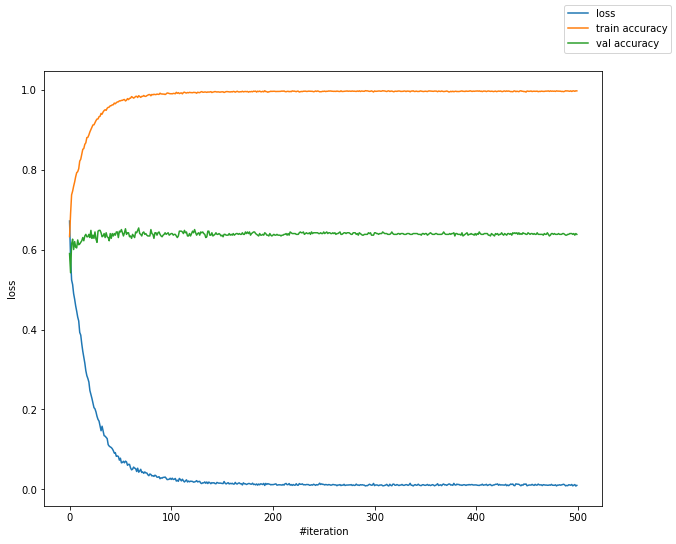

In [13]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [14]:
print("best model:", best_model_name)

best model: classifier_68_0.654.ckpt


In [15]:
best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


In [16]:
print(compute_accuracy(best_model, DataLoader(features_val_dataset, batch_size=500)))

best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)
    
prediction = prediction[:,1].detach().numpy()

auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction)
print(auc_score)

0.654
0.7026240000000001


0.7026240000000001


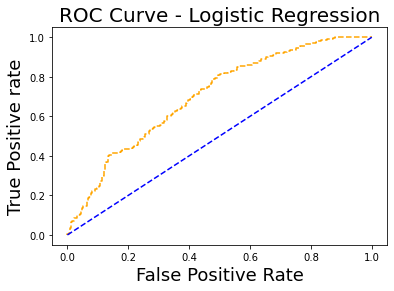

In [17]:
fpr, tpr, thresh = roc_curve(labels_val, prediction, pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction)
print(auc_score)

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve - Logistic Regression', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();